In [21]:
# hide: begin
import os
import warnings

warnings.simplefilter("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# hide: end

from typing import Optional
from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib.axes import Axes

import gpflow
from gpflow.experimental.check_shapes import check_shapes, check_shape

# hide: begin
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 5)
# hide: end

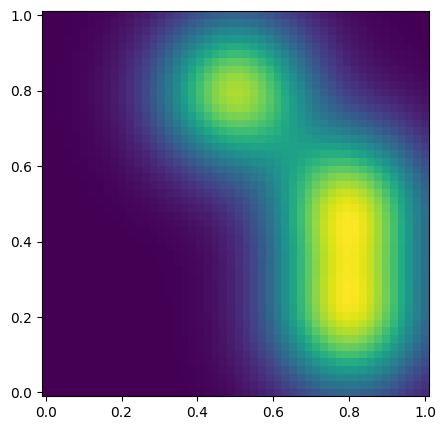

In [29]:
from scipy.stats import multivariate_normal


def plot_data_normals(ax, data, var):
    def _pdf(x):
        r = 0.0
        for d in data:
            r += multivariate_normal.pdf(x, mean=d, cov=var)
        return r / len(data)
    
    n_grid = 50
    Xplots = np.linspace(0.0, 1.0, n_grid)
    Xplot1, Xplot2 = np.meshgrid(Xplots, Xplots)
    Xplot = np.stack([Xplot1, Xplot2], axis=-1)
    Xplot = Xplot.reshape([n_grid ** 2, 2])
    pdf = _pdf(Xplot)
    ax.pcolor(Xplot1, Xplot2, pdf.reshape(Xplot1.shape))
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

data_x = np.array([
    [0.5, 0.8],
    [0.8, 0.5],
    [0.8, 0.2]
])
data_var = np.array(0.02)

plot_data_normals(ax, data_x, data_var)

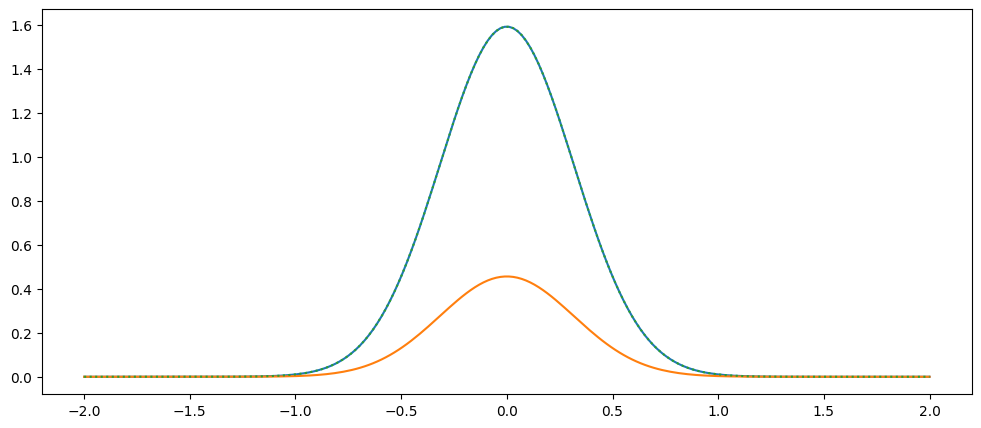

In [45]:
mvn = multivariate_normal((0.0, 0.0), 0.1)
X1 = np.linspace(-2, 2, 200)[:, None]

X2 = np.zeros_like(X1)
X = np.concatenate([X1, X2], axis=1)
pc = mvn.pdf(X)
plt.plot(X1, pc)
sc = np.max(pc)

X2 = 0.5 * np.ones_like(X1)
X = np.concatenate([X1, X2], axis=1)
po = mvn.pdf(X)
plt.plot(X1, po)
so = np.max(po)

plt.plot(X1, po * sc / so, ":")                   

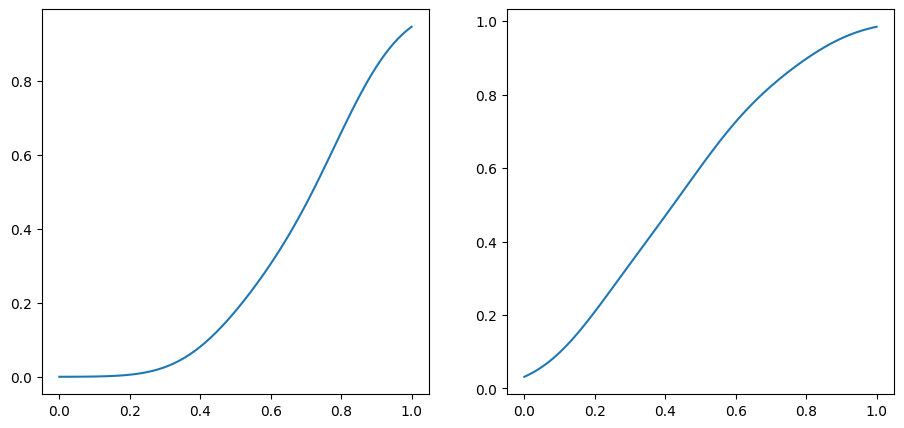

In [111]:
@check_shapes(
    "data: [n_data, n_dim]",
    "var: []",
    "x_leading: [n_x, n_leading_dim]",
    "x: [n_x]",
    "return: [n_x]",
)
def cond_marg_cdf(data, var, x_leading, x):
    data = tf.convert_to_tensor(data)
    var = tf.convert_to_tensor(var)
    x_leading = tf.convert_to_tensor(x_leading)
    x = tf.convert_to_tensor(x)
    dtype = data.dtype
    assert var.dtype == dtype
    assert x_leading.dtype == dtype
    assert x.dtype == dtype
    n_x, n_leading_dim = x_leading.shape
    n_data = len(data)
    data_scale = tf.sqrt(var)
    if n_leading_dim == 0:
        scales = check_shape(
            tf.ones((n_x, n_data), dtype=dtype),
            "[n_x, n_data]",
        )
    else:
        data_dist_mean = check_shape(
            data[:, :n_leading_dim+1],
            "[n_data, n_leading_dim_p1]",
        )
        data_dist_scale = tf.fill((n_data, n_leading_dim+1), data_scale)
        data_dist = tfp.distributions.MultivariateNormalDiag(data_dist_mean, data_dist_scale)
        x_max = check_shape(
            tf.concat([
                tf.tile(x_leading[:, None, :], [1, n_data, 1]),
                tf.tile(data[None, :, n_leading_dim, None], [n_x, 1, 1]),
            ], axis=-1),
            "[n_x, n_data, n_leading_dim_p1]",
        )
        scales = check_shape(
            data_dist.prob(x_max),
            "[n_x, n_data]",
        )
    
    dim_dist = tfp.distributions.Normal(data[:, n_leading_dim], data_scale)
    cdfs = check_shape(
        dim_dist.cdf(x[:, None]),
        "[n_x, n_data]"
    )
    assert scales.dtype == dtype
    assert cdfs.dtype == dtype
    return tf.reduce_sum(
        cdfs * scales / tf.reduce_sum(scales, axis=-1, keepdims=True),
        axis=-1,
    )
    
Nplot = 100
Xplot = np.linspace(0, 1, Nplot)[:, None]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))


y = cond_marg_cdf(data_x, data_var, np.zeros((Nplot, 0)), Xplot[:, 0])
ax1.plot(Xplot, y)

y = cond_marg_cdf(data_x, data_var, np.full((Nplot, 1), 0.7), Xplot[:, 0])
ax2.plot(Xplot, y)

In [123]:
@check_shapes(
    "x_min: [broadcast batch...]",
    "x_max: [broadcast batch...]",
    "y_target: [broadcast batch...]",
    "return: [batch...]"
)
def binary_search(f, x_min, x_max, y_target, n_iter: int = 50):
    x_min = tf.convert_to_tensor(x_min)
    x_max = tf.convert_to_tensor(x_max)
    y_target = tf.convert_to_tensor(y_target)
    shape = tf.broadcast_dynamic_shape(
        tf.broadcast_dynamic_shape(tf.shape(x_min), tf.shape(x_max)),
        tf.shape(y_target),
    )
    x_min = tf.broadcast_to(x_min, shape)
    x_max = tf.broadcast_to(x_max, shape)
    y_target = tf.broadcast_to(y_target, shape)
    for _ in range(n_iter):
        # print("x_min", x_min.shape, x_min.dtype, "x_max", x_max.shape, x_max.dtype)
        x_cur = check_shape(x_min + (x_max - x_min) / 2, "[broadcast batch...]")
        # print("x_cur", x_cur.shape, x_cur.dtype)
        tf.debugging.assert_all_finite(x_cur, "x_cur broken")
        y_cur = check_shape(f(x_cur), "[batch...]")
        # print(float(x_cur), "->", float(y_cur))
        # print("y_cur", y_cur.shape, y_cur.dtype, "y_target", y_target.shape, y_target.dtype)
        tf.debugging.assert_all_finite(y_cur, "y_cur broken")
        is_small = y_cur < y_target
        x_min = tf.where(is_small, x_cur, x_min)
        x_max = tf.where(is_small, x_max, x_cur)
    return x_min

binary_search(lambda x: x**2, 0.0, 10.0, 4.0)

<tf.Tensor: shape=(), dtype=float32, numpy=1.9999999>

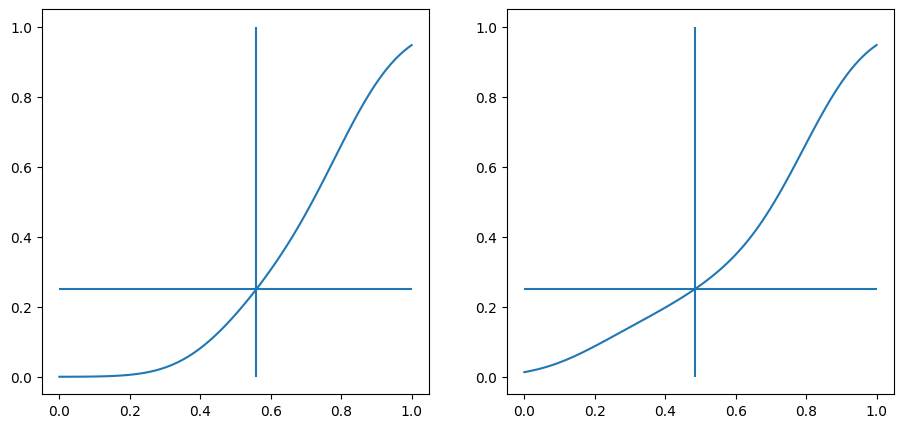

In [124]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
min_bound = np.array(-1e100)
max_bound = np.array(1e100)

n = 100

X1 = np.linspace(0, 1, n)
f = lambda x_candidate: cond_marg_cdf(data_x, data_var, np.zeros((1, 0)), [x_candidate])[0]
y = [f(b) for b in X1]
ax1.plot(X1, y)
xl1 = np.array(0.25)
x1 = binary_search(f, min_bound, max_bound, xl1, n_iter=500)
ax1.hlines(xl1, 0, 1)
ax1.vlines(x1, 0, 1)

X2 = np.linspace(0, 1, n)
f = lambda x_candidate: cond_marg_cdf(data_x, data_var, [[x1]], [x_candidate])[0]
y = [f(b) for b in X2]
ax2.plot(X2, y)
xl2 = np.array(0.25)
x2 = binary_search(f, min_bound, max_bound, xl2, n_iter=500)
ax2.hlines(xl2, 0, 1)
ax2.vlines(x2, 0, 1)

In [133]:
@tf.function
@check_shapes(
    "data: [n_data, n_dim]",
    "var: []",
    "ys: [n_y, n_dim]",
    "return: [n_y, n_dim]",
)
def project_on_data(data, var, ys):
    data = tf.convert_to_tensor(data)
    var = tf.convert_to_tensor(var)
    ys = tf.convert_to_tensor(ys)
    dtype = data.dtype
    min_bound = tf.constant([-1e100], dtype=dtype)
    max_bound = tf.constant([1e100], dtype=dtype)
    result = []
    n_y, n_dim = ys.shape
    x_leading = tf.zeros((n_y, 0), dtype=dtype)
    for d in range(n_dim):
        f = lambda x_candidate: cond_marg_cdf(data, var, x_leading, x_candidate)
        # print("ys[d]", ys[:, d].shape)
        x = binary_search(f, min_bound, max_bound, ys[:, d], n_iter=500)
        x_leading = tf.concat([x_leading, x[:, None]], axis=-1)
    return x_leading

project_on_data(data_x, data_var, np.array([[0.25, 0.25]]))

<tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[0.5589773 , 0.48320788]])>

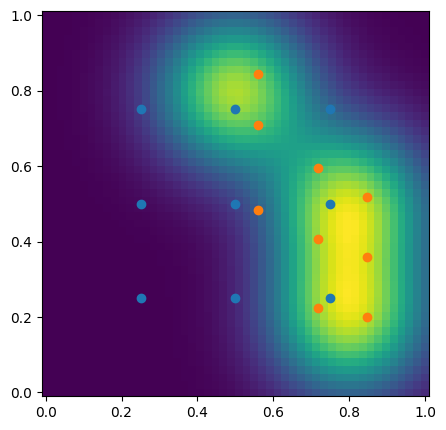

In [138]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_data_normals(ax, data_x, data_var)
ivl = np.array([[0.25, 0.25], [0.25, 0.5], [0.25, 0.75], [0.5, 0.25], [0.5, 0.5], [0.5, 0.75], [0.75, 0.25], [0.75, 0.5], [0.75, 0.75]])
ax.scatter(ivl[:, 0], ivl[:, 1])
ivp = project_on_data(data_x, data_var, ivl)
ax.scatter(ivp[:, 0], ivp[:, 1])

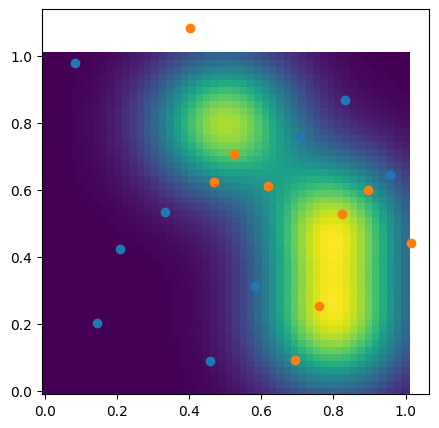

In [140]:
from scipy.stats import qmc

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_data_normals(ax, data_x, data_var)
ivl = qmc.Halton(d=2, scramble=True).random(n=9)
ax.scatter(ivl[:, 0], ivl[:, 1])
ivp = project_on_data(data_x, data_var, ivl)
ax.scatter(ivp[:, 0], ivp[:, 1])